In [1]:
# Last mod: FA 2023 Mar 23 - cosmetics in Figs. 11 & 12

# Testing XGBoost ages for some science cases

First, let's import some libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors, patches
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, MaskedColumn, join
from astropy.visualization import astropy_mpl_style

from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage

import os.path
from itertools import product
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from utils import create_median_map, running_median, overplot_trend, fit_gradient_with_dispersion

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 
font = {'family' : 'serif', 'serif': 'helvet', 'weight' : 'bold', 'size'   : 20}
mpl.rc('font', **font)
mpl.rc('text', usetex=True)

In [3]:
calib        = True
suffix       = "_230314"

if calib:
    agecol = "spec_age"+suffix+"_calib"
else:
    agecol = "spec_age"+suffix
    
uncertcol  = "spec_age"+suffix+"_uncert"

In [4]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Mar2023.fits")
chem_age = np.isfinite(dr17_master['spec_age'+suffix])
our_cat  = dr17_master[chem_age]

In [5]:
len(our_cat)

170340

## Age vs. location in the Galaxy (RGal vs ZGal, XGal vs YGal)

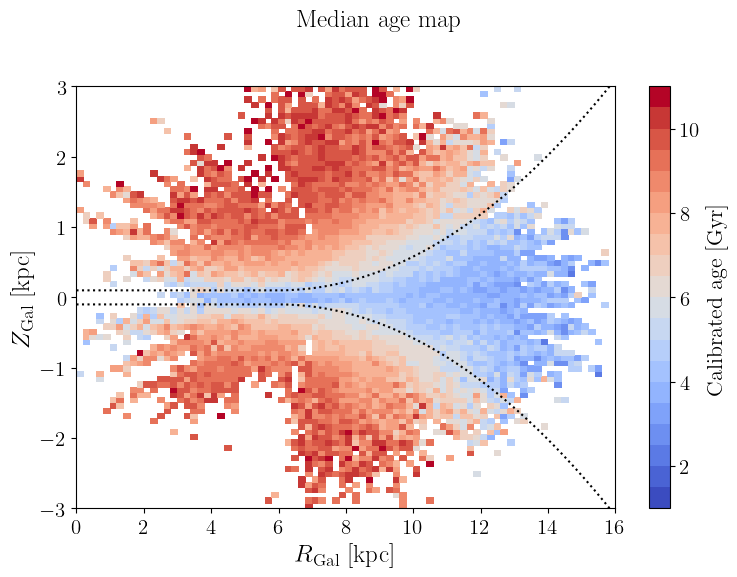

In [6]:
f, (a1) = plt.subplots(1, 1, figsize=(8,6))

rz_range = [0, 16, -3, 3]

XX, YY, H = create_median_map(our_cat["Rg"], our_cat["Zg"],
                              xy_range=rz_range,
                              weights = our_cat[agecol],
                              bins=80, minstars=3)
cmap = plt.get_cmap('coolwarm', 20)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=1, vmax=11)
cax = plt.colorbar(image)
if calib:
    cax.set_label(r"Calibrated age [Gyr]", fontsize=16)
else:
    cax.set_label(r"Spectroscopic age [Gyr]", fontsize=16)

# Overplot flare? 
def flare(R, Rd=6, z0=.1, z1=.03):
    # Only flare if R > Rw:
    return np.piecewise(R, [R < Rd, R >= Rd], 
                        [z0, lambda R:z0 + z1 * (R-Rd)**2.]) 

xarr = np.linspace(0, 20, 100)
plt.plot(xarr, flare(xarr), c="k", ls="dotted")
plt.plot(xarr, flare(xarr, Rd=6, z0=-.1, z1=-.03), c="k", ls="dotted")

a1.axis(rz_range)
a1.set_xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
a1.set_ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)

plt.suptitle("Median age map", fontsize=18)
plt.tight_layout()
plt.savefig("../im/RZ_agecoloured.png")

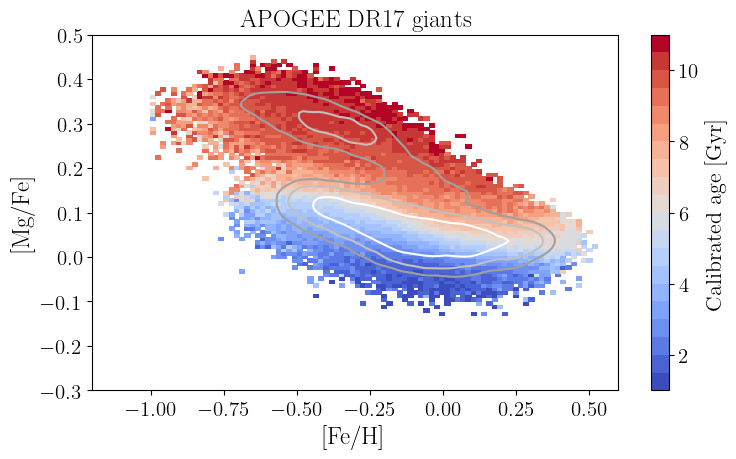

In [7]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

mgfe_range = [-1.2, .6, -.3, .5]

XX, YY, H = create_median_map(our_cat["FE_H"], our_cat["MG_FE"],
                              xy_range=mgfe_range,
                              weights = our_cat[agecol],
                              bins=100)
cmap = plt.get_cmap('coolwarm', 20)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=1, vmax=11, label="APOGEE DR17 giants")
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat["FE_H"], our_cat["MG_FE"], 
                          bins=100, range=[mgfe_range[:2], mgfe_range[2:]])
H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[40, 80, 160],
            colors=['#A0A0A0', '#C0C0C0', 'white'])

cax = plt.colorbar(image)
if calib:
    cax.set_label(r"Calibrated age [Gyr]", fontsize=16)
else:
    cax.set_label(r"Spectroscopic age [Gyr]", fontsize=16)

a1.axis(mgfe_range)
a1.set_xlabel(r"[Fe/H]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.title("APOGEE DR17 giants", fontsize=18)
plt.tight_layout()
plt.savefig("../im/mgfe_agecoloured.png")

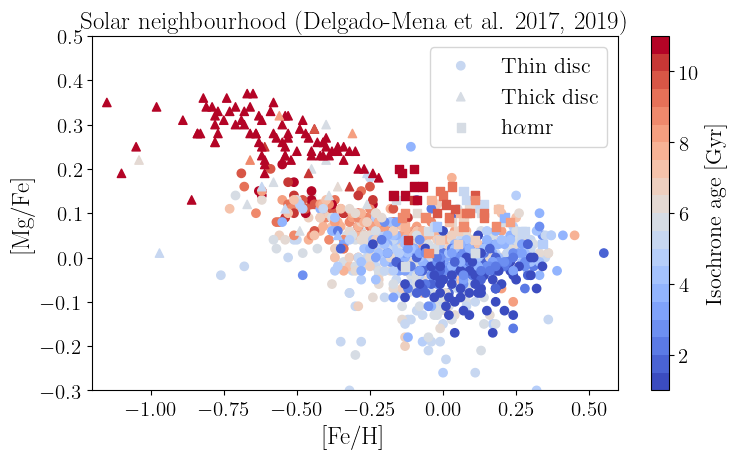

In [8]:
delgadomena = Table.read("../data/DelgadoMena20172019.fits")

f, (a1) = plt.subplots(1, 1, figsize=(8,5))

mgfe_range = [-1.2, .6, -.3, .5]
cmap = plt.get_cmap('coolwarm', 20)

pops = ["thin", "thick", "high"]
syms = ["o", "^", "s"]
labels = ["Thin disc", "Thick disc", r"h$\alpha$mr"]

for jj in [0,1,2]: 
    sc = plt.scatter(delgadomena["__Fe_H_"][delgadomena["pop"]==pops[jj]], 
                     delgadomena["__MgI_Fe_"][delgadomena["pop"]==pops[jj]], 
                     c=delgadomena["Age"][delgadomena["pop"]==pops[jj]], 
                     cmap=cmap, marker=syms[jj], vmin=1, vmax=11, label=labels[jj])

    plt.legend(loc="upper right", fontsize=16)
cax = plt.colorbar(sc)
cax.set_label(r"Isochrone age [Gyr]", fontsize=16)

a1.axis(mgfe_range)
a1.set_xlabel(r"[Fe/H]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.title("Solar neighbourhood (Delgado-Mena et al. 2017, 2019)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/mgfe_agecoloured_delgadomena.png")

## Abundance-age relations

In [9]:
kin_age = our_cat[agecol, 'FE_H',
                  'JR_st_m','JPhi_st_m','JZ_st_m'][(our_cat['JR_st_m']>-9.9) & 
                                                   (our_cat[agecol]>0) &
                                                   (our_cat['FE_H']>-9.)]

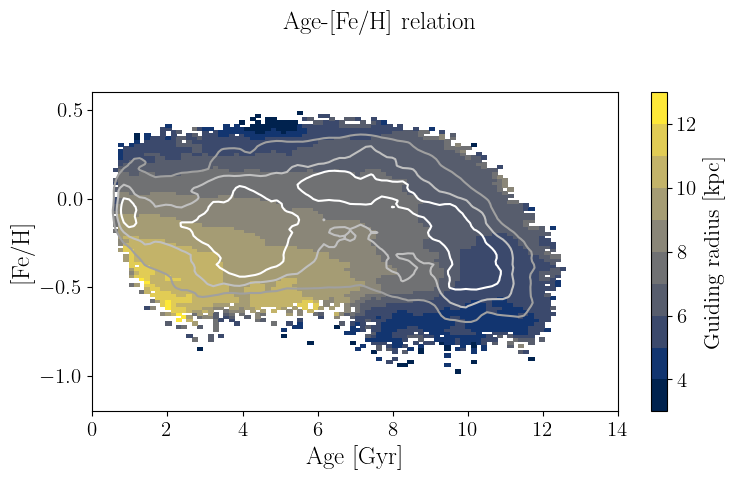

In [10]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

agefe_range = [0,14,-1.2, .6]

XX, YY, H = create_median_map(our_cat[agecol][np.isfinite(our_cat['Rc'])], 
                              our_cat["FE_H"][np.isfinite(our_cat['Rc'])],
                              xy_range=agefe_range,
                              weights = our_cat['Rc'][np.isfinite(our_cat['Rc'])],
                              bins=100, minstars=3, gaussfilter=(1,1))
cmap = plt.get_cmap('cividis', 10)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=3, vmax=13, label="APOGEE DR17 giants")
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat[agecol], our_cat["FE_H"], 
                          bins=100, range=[agefe_range[:2], agefe_range[2:]])
H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[20, 40, 60],
            colors=['#A0A0A0', '#C0C0C0', 'white'])

cax = plt.colorbar(image)
cax.set_label(r"Guiding radius [kpc]", fontsize=16)

a1.axis(agefe_range)
a1.set_xlabel(r"Age [Gyr]", fontsize=18)
a1.set_ylabel(r"[Fe/H]", fontsize=18)

plt.suptitle("Age-[Fe/H] relation", fontsize=18)
plt.tight_layout()
plt.savefig("../im/agefe_Rcoloured.png", dpi=300)

### Compare to the bimodal age-[Fe/H] relation found by Nissen+2020

In [11]:
nissen = Table.read("../data/Nissen2020.fit")
nissen

HD,Teff,logg-sp,Vturb,__Fe_H_,__alpha_Fe_,Zs,logL,Age,e_Age,Mass,logg-ph,Ys,Simbad,_RA,_DE,__C_Fe_,__O_Fe_,__Na_Fe_,__Mg_Fe_,__Al_Fe_,__Si_Fe_,__Ca_Fe_,__Ti_Fe_,__Cr_Fe_,__Ni_Fe_,__Sr_Fe_,__Y_Fe_
,K,log(cm.s**-2),km / s,log(Sun),log(Sun),,log(Sun),Gyr,Gyr,log(Sun),log(cm.s**-2),,,deg,deg,log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun)
int32,int32,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,bytes6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
361,5892,4.524,1.05,-0.13,-0.003,0.0135,-0.021,1.5,0.9,1.01,4.497,0.255,Simbad,2.06817,-14.82449,-0.039,0.01,-0.072,-0.014,-0.042,-0.013,0.027,0.019,0.002,-0.056,0.106,0.079
1461,5760,4.372,1.03,0.19,0.009,0.0275,0.077,5.5,0.5,1.05,4.378,0.257,Simbad,4.67445,-8.053,-0.032,-0.108,0.103,0.007,0.044,0.014,-0.016,0.007,0.005,0.045,-0.052,-0.039
2071,5724,4.486,0.96,-0.087,0.013,0.0152,-0.076,4.1,0.9,0.96,4.481,0.245,Simbad,6.17729,-53.984,-0.02,-0.022,-0.032,0.001,-0.001,0.002,0.024,0.029,0.005,-0.029,0.032,0.039
4915,5662,4.513,0.93,-0.212,0.042,0.0121,-0.154,3.8,1.3,0.92,4.52,0.245,Simbad,12.7952,-5.03928,0.02,0.039,-0.039,0.048,0.02,0.014,0.045,0.064,0.006,-0.037,0.036,0.032
6204,5857,4.517,1.05,0.046,-0.038,0.0188,-0.034,-0.4,1.0,1.05,4.516,0.27,Simbad,15.73925,-9.86124,-0.129,-0.097,-0.107,-0.062,-0.078,-0.044,0.019,-0.009,0.005,-0.064,0.129,0.122
7134,5930,4.322,1.2,-0.335,0.046,0.0093,0.171,8.4,0.5,0.95,4.29,0.208,Simbad,17.88367,-12.84308,0.029,0.094,-0.033,0.037,0.021,0.049,0.047,0.052,-0.018,-0.029,-0.015,-0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204313,5767,4.365,1.05,0.182,0.008,0.027,0.105,6.0,0.5,1.05,4.353,0.253,Simbad,322.05086,-21.72625,0.009,-0.08,0.096,0.01,0.034,0.015,-0.025,-0.001,0.003,0.038,-0.063,-0.058


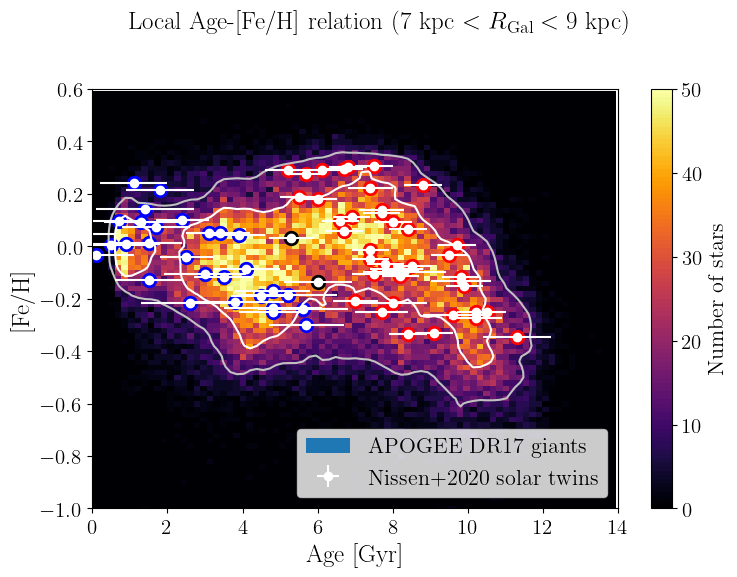

In [12]:
f, (a1) = plt.subplots(1, 1, figsize=(8,6))

agefe_range = [0,14,-1., .6]

sel       = (our_cat['Rg'] > 7) & (our_cat['Rg'] < 9) & (abs(our_cat['Zg']) < 1.)

cmap = plt.get_cmap('inferno', 100)

# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat[agecol][sel], our_cat["FE_H"][sel], 
                          bins=80, range=[agefe_range[:2], agefe_range[2:]])
#Ht[Ht<1]=np.NaN
image = a1.pcolor(X1[:-1], X2[:-1], Ht.T, cmap=cmap, vmax=50, label=r"APOGEE DR17 giants")


H = ndimage.gaussian_filter(Ht,sigma=(1.,1.),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[10, 25],
            colors=['#C0C0C0', 'white'])

plt.errorbar(nissen["Age"], nissen["__Fe_H_"], 
             xerr=nissen["e_Age"], yerr=0.01, fmt = 'o', c="w",
             label="Nissen+2020 solar twins")

cax = plt.colorbar(image)
cax.set_label(r"Number of stars", fontsize=16)

a1.axis(agefe_range)
a1.set_xlabel(r"Age [Gyr]", fontsize=18)
a1.set_ylabel(r"[Fe/H]", fontsize=18)

plt.legend(loc="lower right", fontsize=16)

# Nissen colors:
young = (nissen["__Fe_H_"] < -0.2 * (nissen["Age"]-4.5))
old   = (nissen["__Fe_H_"] > -0.2 * (nissen["Age"]-5.9))

plt.scatter(nissen["Age"][young], nissen["__Fe_H_"][young], 
            edgecolors="b", c="w", linewidths=5)
plt.scatter(nissen["Age"][old], nissen["__Fe_H_"][old], 
            edgecolors="r", c="w", linewidths=5)
plt.scatter(nissen["Age"][~old&~young], nissen["__Fe_H_"][~old&~young], 
            edgecolors="k", c="w", linewidths=5)

plt.suptitle(r"Local Age-[Fe/H] relation (7 kpc $<R_{\rm Gal}<9$ kpc)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/agefe_local.png", dpi=300)

## Age - [Mg/Fe] relation

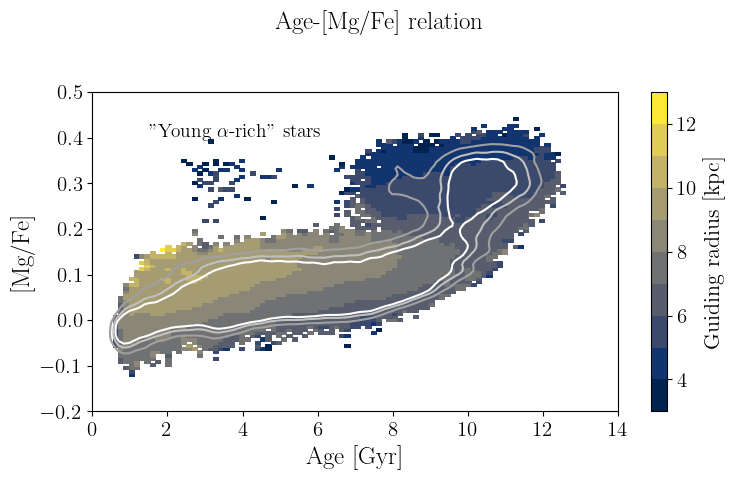

In [13]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

agefe_range = [0,14,-.2, .5]

XX, YY, H = create_median_map(our_cat[agecol][np.isfinite(our_cat['Rc'])], 
                              our_cat["MG_FE"][np.isfinite(our_cat['Rc'])],
                              xy_range=agefe_range,
                              weights = our_cat['Rc'][np.isfinite(our_cat['Rc'])],
                              bins=100, minstars=3, gaussfilter=(1,1))
cmap = plt.get_cmap('cividis', 10)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=3, vmax=13, label="APOGEE DR17 giants")
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat[agecol], our_cat["MG_FE"], 
                          bins=100, range=[agefe_range[:2], agefe_range[2:]])
H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[20, 40, 60],
            colors=['#A0A0A0', '#C0C0C0', 'white'])

cax = plt.colorbar(image)
cax.set_label(r"Guiding radius [kpc]", fontsize=16)

a1.text(1.5, .4, r'"Young $\alpha$-rich" stars', fontsize=14)

a1.axis(agefe_range)
a1.set_xlabel(r"Age [Gyr]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.suptitle("Age-[Mg/Fe] relation", fontsize=18)
plt.tight_layout()
plt.savefig("../im/agemgfe_Rcoloured.png", dpi=300)

## What next?

In [14]:
# Recompute guiding centres in the same way as Bridget:
_vc_sun = 229.76
our_cat['Rc'] = our_cat['Rg'] * our_cat["vPhig"] / _vc_sun

2807
9372
28491
34058
27005
23909
11648


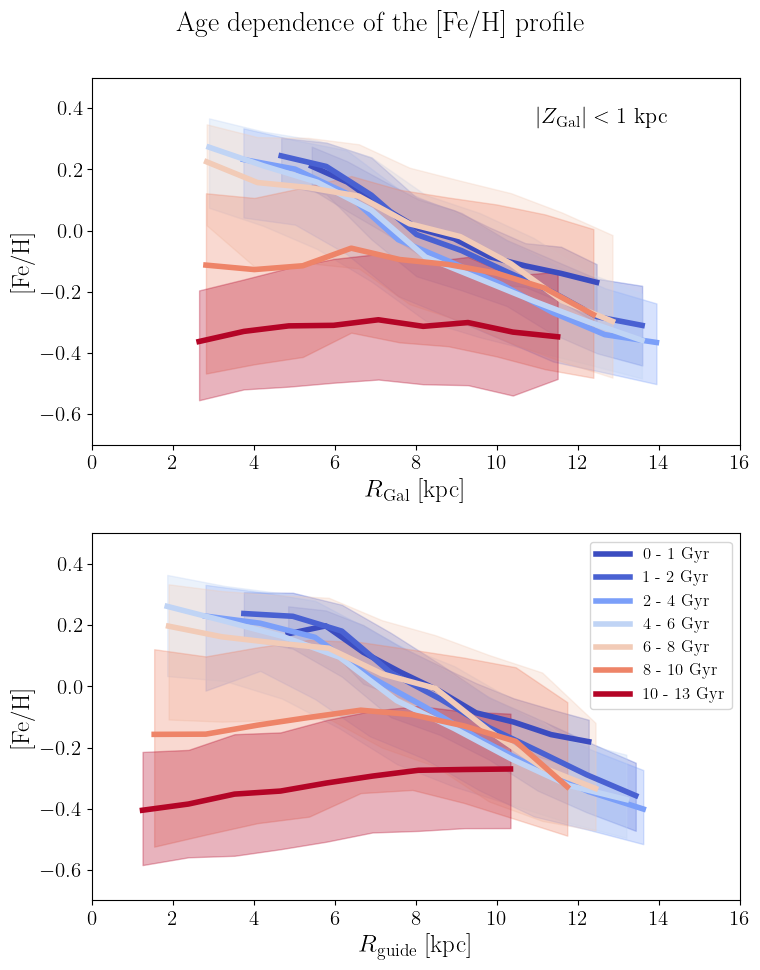

In [15]:
f, (a0, a1) = plt.subplots(2,1, figsize=(8,10))
f.subplots_adjust(right=0.8)

plot_cbar = False
rfe_range = [0, 16, -.7, .5]
ageranges = [[0,1], [1,2], [2,4], [4,6], [6,8], [8,10], [10,13]] 
dfedr     = np.zeros(len(ageranges))
sigfe     = np.zeros(len(ageranges))
dfedrg    = np.zeros(len(ageranges))
sigfeg    = np.zeros(len(ageranges))
rrange    = [5, 11]

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=1, vmax=11)

plt.axes(a0)
for ii in np.arange(len(ageranges)):
    cut_ii = (our_cat[agecol] > ageranges[ii][0]) & \
             (our_cat[agecol] < ageranges[ii][1]) & \
             (abs(our_cat['Zg']) < 1.) & (np.isfinite(our_cat['FE_H']))
    print(np.sum(cut_ii))
    if np.sum(cut_ii)<100:
        pass
    else:
        Rs, med, q16, q84, N = running_median(our_cat['Rg'][cut_ii], our_cat['FE_H'][cut_ii], nbins=10)
        med = np.array(med)
        dfedr[ii] = np.polyfit(Rs[(Rs>rrange[0]) & (Rs<rrange[1])], med[(Rs>rrange[0]) & (Rs<rrange[1])], 1)[0]
        sigfe[ii] = np.mean(0.5 * (np.array(q84)-np.array(q16)))
        l = overplot_trend(our_cat['Rg'][cut_ii], our_cat['FE_H'][cut_ii], 
                           alpha=0.3, bins=10, lw=4, 
                           color=cmap(norm(0.5*(ageranges[ii][0]+ageranges[ii][1]))),
                           label=str(ageranges[ii][0])+r" - "+str(ageranges[ii][1])+r" Gyr")

a0.axis(rfe_range)
a0.set_xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
a0.set_ylabel(r"[Fe/H]", fontsize=18)
plt.text(11, 0.35, r"$|Z_{\rm Gal}|<1$ kpc", fontsize=16)

plt.axes(a1)
for ii in np.arange(len(ageranges)):
    cut_ii = (our_cat[agecol] > ageranges[ii][0]) & \
             (our_cat[agecol] < ageranges[ii][1]) & \
             (abs(our_cat['Zg']) < 1.) & (np.isfinite(our_cat['FE_H'])) & (our_cat['Rc']>0)
    if np.sum(cut_ii)<100:
        pass
    else:
        Rs, med, q16, q84, N = running_median(our_cat['Rc'][cut_ii], our_cat['FE_H'][cut_ii], nbins=10)
        med = np.array(med)
        dfedrg[ii] = np.polyfit(Rs[(Rs>rrange[0]) & (Rs<rrange[1])], med[(Rs>rrange[0]) & (Rs<rrange[1])], 1)[0]
        sigfeg[ii] = np.mean(0.5 * (np.array(q84)-np.array(q16)))
        l = overplot_trend(our_cat['Rc'][cut_ii], our_cat['FE_H'][cut_ii], 
                           alpha=0.3, bins=10, lw=4,
                           color=cmap(norm(0.5*(ageranges[ii][0]+ageranges[ii][1]))),
                           label=str(ageranges[ii][0])+r" - "+str(ageranges[ii][1])+r" Gyr")

plt.legend(loc="upper right", fontsize=12)

a1.axis(rfe_range)
a1.set_xlabel(r"$R_{\rm guide}$ [kpc]", fontsize=18)
a1.set_ylabel(r"[Fe/H]", fontsize=18)

plt.suptitle("Age dependence of the [Fe/H] profile", fontsize=20)
if plot_cbar:
    fakedots = plt.scatter(-our_cat['Rc'][10], -our_cat['Rc'][10], 
                       c=our_cat['spec_age_feb2023'][10], vmin=1, vmax=11, cmap=cmap)

    cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
    cax = f.colorbar(fakedots, cax=cbar_ax, label="Age [Gyr]")
    cax.set_label(r"Age [Gyr]", fontsize=16)
else:
    plt.tight_layout()
plt.savefig("../im/Rfe_agecoloured.png", dpi=300)

/tmp/ipykernel_23246/2868037041.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xarr, yarr, c="k", ls="dashdot", fmt = 'o-', markersize=10,


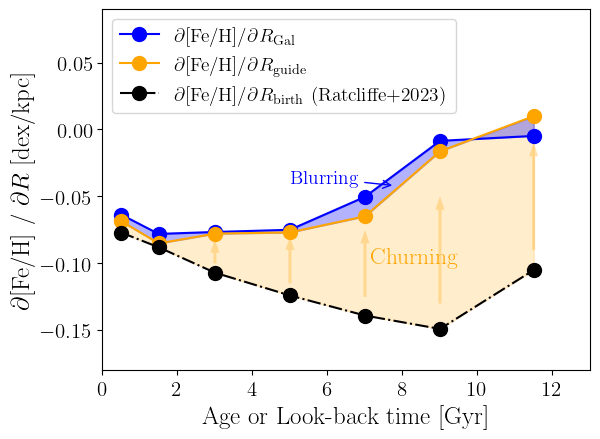

In [16]:
# Age array
xarr =  np.array([0.5*(a[0]+a[1]) for a in ageranges])

# Plot poor man's gradient computation
plt.errorbar(xarr, dfedr, markersize=10,
             fmt = 'o-', c="b", label=r"$\partial$[Fe/H]/$\partial R_{\rm Gal}$")
plt.errorbar(xarr, dfedrg, markersize=10,
             fmt = 'o-', c="orange", label=r"$\partial$[Fe/H]/$\partial R_{\rm guide}$")

# Overplot Bridget's gradients (read off her Fig. 5)
yarr = -np.array([0.077, 0.088, 0.107, 0.124, 0.139, 0.149, 0.105 ])
plt.errorbar(xarr, yarr, c="k", ls="dashdot", fmt = 'o-', markersize=10,
             label=r"$\partial$[Fe/H]/$\partial R_{\rm birth}$ (Ratcliffe+2023)")

# Shaded regions
plt.fill_between(xarr, yarr, dfedrg, alpha=0.2, zorder=0, color="orange")
plt.fill_between(xarr, dfedr, dfedrg, alpha=0.3, zorder=0, color="blue")
# Arrows
arr_x = [3,5,7,9,11.5]
arr_y = [-.1, -.115, -.125, -.13, -.09]
dy    = [.008, .025, .04, .07, .07]
for ii in np.arange(len(dy)):
    plt.arrow(x=arr_x[ii], y=arr_y[ii], dx=0, dy=dy[ii], 
              width=.08, head_length=.01, alpha=0.3, facecolor='orange', edgecolor='none')
plt.text(7.15, -.1, r"Churning", fontsize=17, color="orange")
#plt.text(7.15, -.1, r"Blurring", fontsize=15, color="blue")
plt.annotate(r"Blurring", fontsize=14, color="blue",
            xy=(7.8, -0.042), xycoords='data',
            xytext=(5, -0.04), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="b"))

plt.legend(loc="upper left", fontsize=14)

plt.axis([0,13,-.18, 0.09])
plt.xlabel(r"Age or Look-back time [Gyr]", fontsize=18)
plt.ylabel(r"$\partial$[Fe/H] / $\partial R$   [dex/kpc]", fontsize=18)

plt.tight_layout()
plt.savefig("../im/dfedr_age.png")

## Try something a bit more sophisticated:
### Fitting the age dependence of the [Fe/H] gradient as in Anders+2017

Demonstrate how it works for the Cepheid compilation of Genovali+2014:

Least-squares results:
        m = -0.0513891566616923 ± 0.0020033211048246066 
        b = 0.4973046958919003 ± 0.019400912397937026 
    
Maximum likelihood result:
            m = -0.05172740019828823 
            b = 0.5025742996784139 
            f = 0.1102086484279268 
        
Running MCMC...
Done.
MCMC result:
            m = -0.05168430195580191 +0.003183521988170075 -0.0030922879041399565 
            b = 0.5020539741085601 +0.02954456287685492 -0.030569046297205693 
            f = 0.11111764773673019 +0.006875425679620711 -0.006941689999107076 
        


/home/friedel/Desktop/xgboost_chem_ages/py/utils.py:204: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(x, y, yerr=yerr, fmt=".k", c="k", alpha=0.2)
/home/friedel/Desktop/xgboost_chem_ages/py/utils.py:219: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(xl, m_mcmc[0]*xl+b_mcmc[0], "k", c='blue')
/home/friedel/Desktop/xgboost_chem_ages/py/utils.py:232: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(x, y, yerr=yerr, fmt=".k", c="k", alpha=0.2)


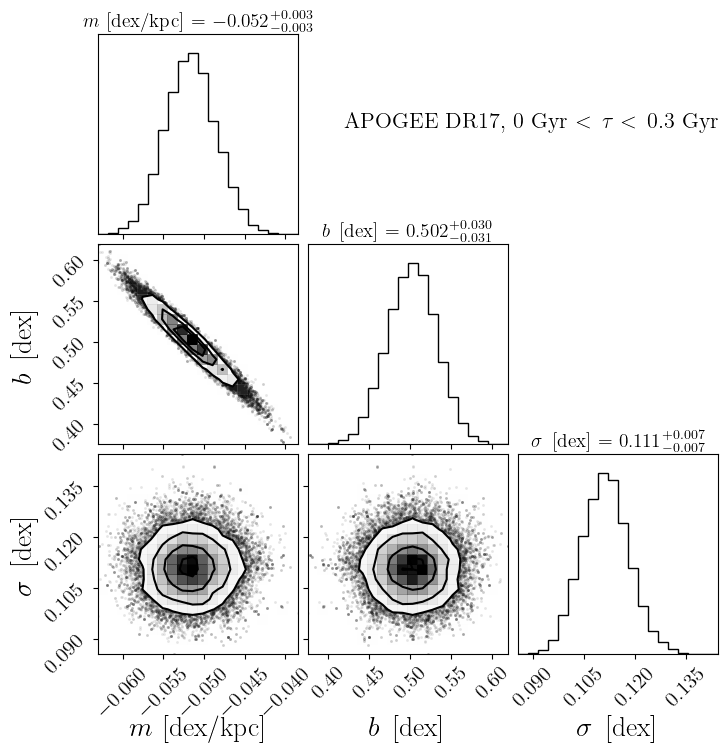

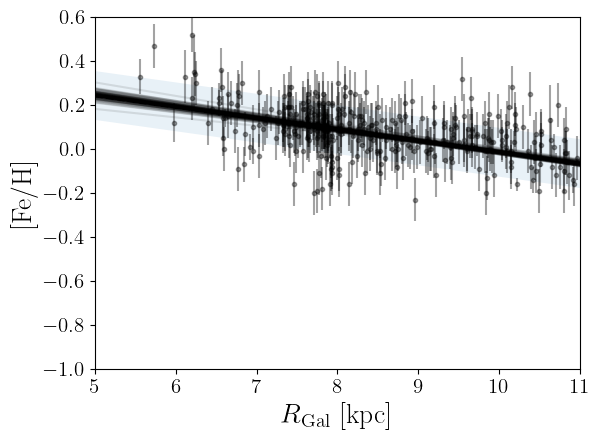

In [17]:
# READ CEPHEID & OPEN CLUSTER DATA from Genovali+2014
ceph1 = Table.read("../data/Genovali2014_cepheids.fits")
ceph2 = Table.read("../data/Genovali2014_literature_cepheids.fits")
# Concatenate the 2 tables
Rcep   = np.concatenate( (ceph1['Rgal']/1000., ceph2['Rgal']/1000.) ) + 0.25 # solar correction
Fecep  = np.concatenate( (ceph1['__Fe_H_'], ceph2['__Fe_H_']) )
e_Fecep= np.concatenate((ceph1['e__Fe_H_'], 0.1*np.ones(len(ceph2['e__Fe_H_'])) ))

# Now do the fitting:
m, b, f = fit_gradient_with_dispersion(Rcep, Fecep, e_Fecep, np.ones(len(Rcep)), Nfit=3, agebounds=[0, 0.3])

### Apply the same method for the APOGEE DR17 sample in narrow age bins 

In [18]:
gradientpath = "../data/gradients_agebins_Z_lt_0p3.npz"

if os.path.exists(gradientpath):
    # Read the results of the previously computed 3-parameter fits from the .npz file
    res = np.load(gradientpath)
    agebins = res["agebins"]
    marr    = res["marr"]
    barr    = res["barr"]
    farr    = res["farr"]
    marrg   = res["marrg"]
    barrg   = res["barrg"]
    farrg   = res["farrg"]
else:
    # Do the computation
    Nbins     = 24
    agebins   = np.linspace(0.5,12,Nbins)
    print(agebins)
    marr, barr, farr = np.zeros((Nbins,3)), np.zeros((Nbins,3)), np.zeros((Nbins,3))
    print("Fitting", np.sum((abs(our_cat['Zg']) < 0.3) & (np.isfinite(our_cat['FE_H'])) & \
                            (our_cat['Rg'] > rrange[0]) & (our_cat['Rg'] < rrange[1])), "stars")
    for ii in np.arange(len(agebins)-1):
        cut_ii = (our_cat[agecol] > agebins[ii]) & \
                 (our_cat[agecol] < agebins[ii+1]) & \
                 (abs(our_cat['Zg']) < 0.3) & (np.isfinite(our_cat['FE_H'])) & \
                 (our_cat['Rg'] > rrange[0]) & (our_cat['Rg'] < rrange[1])
        print("Age bin", agebins[ii], "-", agebins[ii+1], "Gyr:", np.sum(cut_ii), "stars")
        m, b, f = fit_gradient_with_dispersion(our_cat['Rg'][cut_ii], our_cat['FE_H'][cut_ii], 
                                               our_cat['FE_H_ERR'][cut_ii], np.ones(np.sum(cut_ii)), 
                                               Nfit=3, agebounds=[agebins[ii], agebins[ii+1]])
        marr[ii,:] = m
        barr[ii,:] = b
        farr[ii,:] = f

    marrg, barrg, farrg = np.zeros((Nbins,3)), np.zeros((Nbins,3)), np.zeros((Nbins,3))
    print("Fitting", np.sum((abs(our_cat['Zg']) < 0.3) & (np.isfinite(our_cat['FE_H'])) & \
                            (our_cat['Rc'] > rrange[0]) & (our_cat['Rc'] < rrange[1])), "stars")
    for ii in np.arange(len(agebins)-1):
        cut_ii = (our_cat[agecol] > agebins[ii]) & \
                 (our_cat[agecol] < agebins[ii+1]) & \
                 (abs(our_cat['Zg']) < 0.3) & (np.isfinite(our_cat['FE_H'])) & \
                 (our_cat['Rc'] > rrange[0]) & (our_cat['Rc'] < rrange[1])
        print("Age bin", agebins[ii], "-", agebins[ii+1], "Gyr:", np.sum(cut_ii), "stars")
        m, b, f = fit_gradient_with_dispersion(np.array(our_cat['Rc'][cut_ii]), 
                                               np.array(our_cat['FE_H'][cut_ii]), 
                                               np.array(our_cat['FE_H_ERR'][cut_ii]), np.ones(len(our_cat['Rc'][cut_ii])), 
                                               Nfit=3, agebounds=[agebins[ii], agebins[ii+1]],
                                               guide=True)
        marrg[ii,:] = m
        barrg[ii,:] = b
        farrg[ii,:] = f

    np.savez("../data/gradients_agebins_Z_lt_0p3.npz", agebins=agebins, 
             marr=marr, barr=barr, farr=farr, marrg=marrg, barrg=barrg, farrg=farrg)

Plot the results:

/tmp/ipykernel_23246/4057471859.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xarr, bridget_to_plot[:,1], c="k", ls="dashdot", fmt = 'o-', markersize=4,


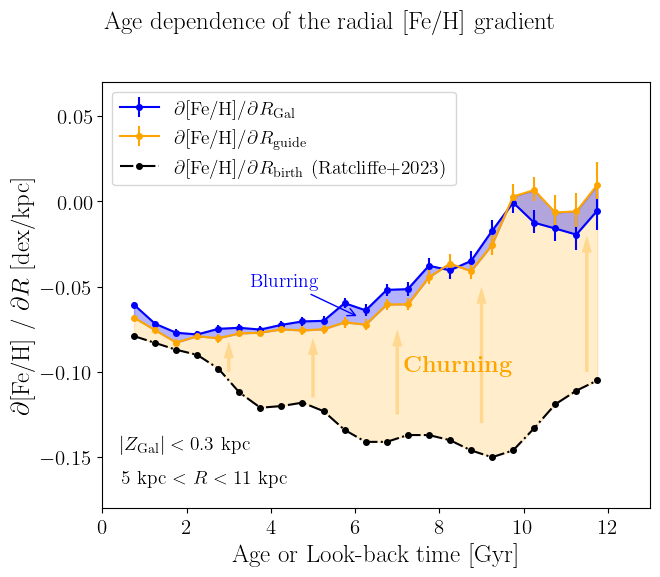

In [19]:
# Age array
xarr =  0.5*(agebins[:-1]+agebins[1:])

f, (a1) = plt.subplots(1, 1, figsize=(7,6))
# Plot gradient as a function of age
plt.errorbar(xarr, marr[:-1,0], yerr=[marr[:-1,1], marr[:-1,2]], markersize=4,
             fmt = 'o-', c="b", label=r"$\partial$[Fe/H]/$\partial R_{\rm Gal}$")
plt.errorbar(xarr, marrg[:-1,0], yerr=[marrg[:-1,1], marrg[:-1,2]], markersize=4,
             fmt = 'o-', c="orange", label=r"$\partial$[Fe/H]/$\partial R_{\rm guide}$")

# Overplot Bridget's gradients (read off the data from her Fig. 5)
bridget = np.array([[0.25,-0.075], [0.5,-0.077], [0.75,-0.079], [1,-0.081], [1.25,-0.083], [1.5,-0.085],
                    [1.75,-0.087], [2,-0.089], [2.25,-0.09], [2.5,-0.092], [2.75,-0.098], [3,-0.105],
                    [3.25,-0.112], [3.5,-0.119], [3.75,-0.121], [4,-0.122], [4.25,-0.12], [4.5,-0.117],
                    [4.75,-0.118], [5,-0.119], [5.25,-0.123], [5.5,-0.127], [5.75,-0.134], [6,-0.14],
                    [6.25,-0.141], [6.5,-0.141], [6.75,-0.141], [7,-0.139], [7.25,-0.137], [7.5,-0.136],
                    [7.75,-0.137], [8,-0.138], [8.25,-0.14], [8.5,-0.143], [8.75,-0.146], [9,-0.15],
                    [9.25,-0.15], [9.5,-0.15], [9.75,-0.146], [10,-0.141], [10.25,-0.133], [10.5,-0.124],
                    [10.75,-0.119], [11,-0.115], [11.25,-0.111], [11.5,-0.107], [11.75,-0.105]])
#yarr = -np.array([0.077, 0.088, 0.107, 0.124, 0.139, 0.149, 0.105 ])
bridget_to_plot = np.array([bridget[ii,:] for ii in range(len(bridget)) if bridget[ii, 0] in xarr])
plt.errorbar(xarr, bridget_to_plot[:,1], c="k", ls="dashdot", fmt = 'o-', markersize=4,
             label=r"$\partial$[Fe/H]/$\partial R_{\rm birth}$ (Ratcliffe+2023)")

# Shaded regions
plt.fill_between(xarr, bridget_to_plot[:,1], marrg[:-1,0], alpha=0.2, zorder=0, color="orange")
plt.fill_between(xarr, marr[:-1,0], marrg[:-1,0], alpha=0.3, zorder=0, color="blue")
# Arrows
arr_x = [3,5,7,9,11.5]
arr_y = [-.1, -.115, -.125, -.13, -.10]
dy    = [.008, .025, .04, .07, .07]
for ii in np.arange(len(dy)):
    plt.arrow(x=arr_x[ii], y=arr_y[ii], dx=0, dy=dy[ii], 
              width=.08, head_length=.01, alpha=0.3, facecolor='orange', edgecolor='none')
plt.text(7.15, -.1, r"$\textbf{Churning}$", fontsize=17, color="orange")
#plt.text(7.15, -.1, r"Blurring", fontsize=15, color="blue")
plt.annotate(r"Blurring", fontsize=14, color="blue",
            xy=(6.1, -0.068), xycoords='data',
            xytext=(3.5, -0.05), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="b"))

plt.legend(loc="upper left", fontsize=14)

plt.axis([0,13,-.18, 0.07])
plt.xlabel(r"Age or Look-back time [Gyr]", fontsize=18)
plt.ylabel(r"$\partial$[Fe/H] / $\partial R$   [dex/kpc]", fontsize=18)

plt.text(0.45, -0.145, r"$|Z_{\rm Gal}|<0.3$ kpc", fontsize=14)
plt.text(0.45, -0.165, r"5 kpc $<R<11$ kpc", fontsize=14)
plt.suptitle(r"Age dependence of the radial [Fe/H] gradient\\ ", fontsize=18)

plt.tight_layout()
plt.savefig("../im/dfedr_age_bayes_Z_lt_0p3.png", dpi=300)

Power-law fit for Rguide grad [Fe/H] dispersion: [ 0.31389905  0.14810201 -0.2190932 ]
Power-law fit for Rgal grad [Fe/H] dispersion: [ 0.4126156   0.11726227 -0.3135362 ]


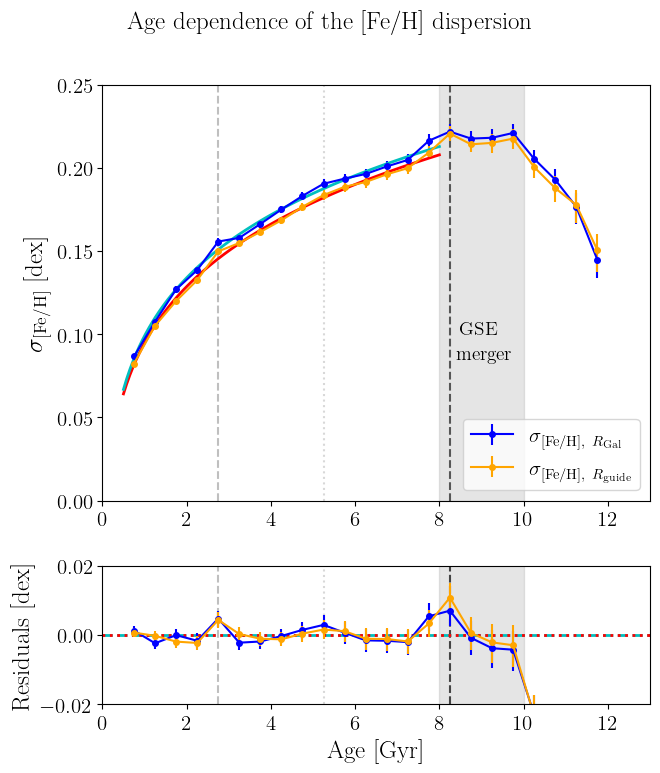

In [45]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(7,8))

# Top panel: Plot sigma_[Fe/H] obtained from the gradient fits
plt.axes(a0)
plt.errorbar(xarr, farr[:-1,0], yerr=[farr[:-1,1], farr[:-1,2]], markersize=4,
             fmt = 'o-', c="b", label=r"$\sigma_{{\rm [Fe/H]},\ R_{\rm Gal}}$")
plt.errorbar(xarr, farrg[:-1,0], yerr=[farrg[:-1,1], farrg[:-1,2]], markersize=4,
             fmt = 'o-', c="orange", label=r"$\sigma_{{\rm [Fe/H]},\ R_{\rm guide}}$")
# Try to fit the orange points up to 7 Gyr by a constant + power law
from scipy.optimize import curve_fit
def fitfunc(x, a, b, c):
    return a * x**b + c
popt,  pcov  = curve_fit(fitfunc, xarr[xarr<7], farrg[:-1,0][xarr<7])
popt2, pcov2 = curve_fit(fitfunc, xarr[xarr<7], farr[:-1,0][xarr<7])
print("Power-law fit for Rguide grad [Fe/H] dispersion:", popt)
print("Power-law fit for Rgal grad [Fe/H] dispersion:", popt2)
xplot      = np.linspace(0.5, 8, 100)
plt.legend(loc="lower right", fontsize=15)
plt.plot(xplot, fitfunc(xplot, *popt), 'r-', lw=2, label=r"$\sigma_{\rm [Fe/H]}\propto {\rm age}^{0.15}$")
plt.plot(xplot, fitfunc(xplot, *popt2), 'c-', lw=2, label=r"$\sigma_{\rm [Fe/H]}\propto {\rm age}^{0.12}$")
plt.axvline(2.75, c="grey", ls="dashed", alpha=.5, zorder=0)
plt.axvline(5.25, c="grey", ls="dotted", alpha=.3, zorder=0)
plt.axvline(8.25, c="k", ls="dashed", alpha=.7, zorder=0)
#plt.annotate(r"Star-formation ", fontsize=14, 
#            xy=(2.75, 0.145), xycoords='data',
#            xytext=(2.85, 0.1), textcoords='data',
#            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#plt.text(3.35, 0.085, "burst?", fontsize=14)
#plt.text(3.75, 0.07, "(Mor+2019)", fontsize=14)

plt.text(8.5, 0.1, "GSE", fontsize=14)
plt.text(8.4, 0.085, "merger", fontsize=14)

plt.axis([0,13,0, 0.25])
plt.ylabel(r"$\sigma_{\rm [Fe/H]} $ [dex]", fontsize=18)
plt.fill_between(np.linspace(8,10,10), 0, 100, alpha=0.2, zorder=0, color="grey")

# Bottom panel: residuals
plt.axes(a1)

plt.errorbar(xarr, farr[:-1,0]-fitfunc(xarr, *popt2), yerr=[farr[:-1,1], farr[:-1,2]], markersize=4,
             fmt = 'o-', c="b", label=r"$\sigma_{{\rm [Fe/H]},\ R_{\rm Gal}}$")
plt.errorbar(xarr, farrg[:-1,0]-fitfunc(xarr, *popt), yerr=[farrg[:-1,1], farrg[:-1,2]], markersize=4,
             fmt = 'o-', c="orange", label=r"$\sigma_{{\rm [Fe/H]},\ R_{\rm guide}}$")
plt.fill_between(np.linspace(8,10,10), -10, 10, alpha=0.2, zorder=0, color="grey")
plt.axvline(2.75, c="grey", ls="dashed", alpha=.5, zorder=0)
plt.axvline(5.25, c="grey", ls="dotted", alpha=.3, zorder=0)
plt.axvline(8.25, c="k", ls="dashed", alpha=.7, zorder=0)
plt.axhline(0, c="c", ls="dashed", alpha=1, zorder=0, lw=2)
plt.axhline(0, c="r", ls="dotted", alpha=1, zorder=0, lw=2)
plt.axis([0,13,-0.02, 0.02])
plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Residuals [dex]", fontsize=18)

plt.suptitle(r"Age dependence of the [Fe/H] dispersion\\ ", fontsize=18)
plt.tight_layout()
plt.savefig("../im/sigfe_age_bayes_Z_lt_0p3.png", dpi=300)

## Age - velocity dispersion relation in bins of R

6048
15433
57652
Power-law fit for AVR  7 - 9  kpc bin: [16.14659523  0.29212998 -6.71615917]
Linear fit for AVR  7 - 9  kpc bin [7-11 Gyr]: [  4.93272088 -15.17187264]
40648
14261


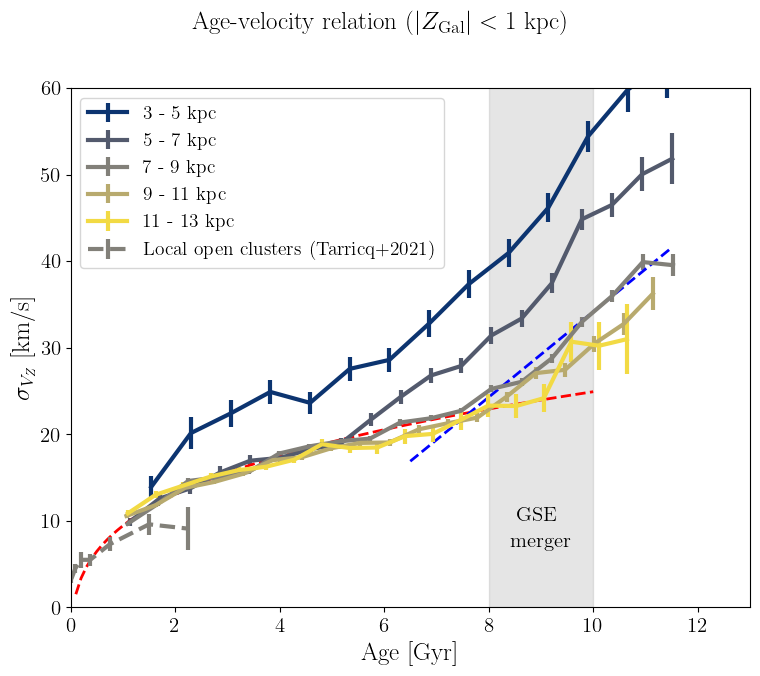

In [57]:
f, (a0) = plt.subplots(1,1, figsize=(8,7))
f.subplots_adjust(right=0.8)

plot_cbar = False
Rbins     = [[3,5], [5,7], [7,9], [9,11], [11, 13]]

import matplotlib as mpl
cmap = plt.get_cmap('cividis', 20)
norm = mpl.colors.Normalize(vmin=3, vmax=13)

plt.axes(a0)
for ii in np.arange(len(Rbins)):
    cut_ii = (our_cat['Rg'] > Rbins[ii][0]) & \
             (our_cat['Rg'] < Rbins[ii][1]) & \
             (abs(our_cat['Zg']) < 1.) & (np.isfinite(our_cat['vZg']))
    N_ii = np.sum(cut_ii)
    print(N_ii)
    ages, med, q16, q84, N = running_median(our_cat[agecol][cut_ii], 
                                         our_cat['vZg'][cut_ii], nbins=np.minimum(int(N_ii / 400), 20))
    
    plt.errorbar(np.array(ages), 0.5*(np.array(q84)-np.array(q16)), ms=50, lw=3, ls="solid",
             color=cmap(norm(0.5*(Rbins[ii][0]+Rbins[ii][1]))), 
                   yerr=0.5*(np.array(q84)-np.array(q16))/np.sqrt(N),
             label=str(Rbins[ii][0])+r" - "+str(Rbins[ii][1])+r" kpc")
    if ii == 2:
        popt,  pcov  = curve_fit(fitfunc, np.array(ages)[ages<7], 0.5*(np.array(q84)-np.array(q16))[ages<7])
        print("Power-law fit for AVR ", str(Rbins[ii][0]), "-", str(Rbins[ii][1]), " kpc bin:", popt)
        xplot      = np.linspace(0.1, 10, 100)
        plt.plot(xplot, fitfunc(xplot, *popt), 'r--', lw=2)
        def fitfunc2(x, m, n):
            return m * x + n
        popt2,  pcov  = curve_fit(fitfunc2, np.array(ages)[(ages>7)&(ages<11)], 
                                 0.5*(np.array(q84)-np.array(q16))[(ages>7)&(ages<11)])
        print("Linear fit for AVR ", str(Rbins[ii][0]), "-", str(Rbins[ii][1]), " kpc bin [7-11 Gyr]:", popt2)
        xplot      = np.linspace(6.5, 11.5, 100)
        plt.plot(xplot, fitfunc2(xplot, *popt2), 'b--', lw=2)



    
# Adding the (local) OC measurements from Tarricq+2021, Table 3:
ages_t = [0.015, 0.09, 0.2, 0.375, 0.75, 1.5, 2.25]
sigs_t = [3.3, 4.5, 5.5, 5.5, 7.3, 9.6, 9.1]
errs_t = [.5,.5,.9,.7,.8,1.2,2.5]

plt.errorbar(ages_t, sigs_t, ms=50, lw=3, ls="dashed",
             color=cmap(norm(8.2)), yerr=errs_t,
             label="Local open clusters (Tarricq+2021)")

plt.legend(loc="upper left", fontsize=14)
a0.axis([0,13,0,60])
a0.set_xlabel(r"Age [Gyr]", fontsize=18)
a0.set_ylabel(r"$\sigma_{V_Z}$ [km/s]", fontsize=18)
a0.fill_between(np.linspace(8,10,10), 0, 100, alpha=0.2, zorder=0, color="grey")

plt.text(8.55, 10, "GSE", fontsize=15)
plt.text(8.4, 7, "merger", fontsize=15)
#plt.text(10.05, 11, r"$|Z_{\rm Gal}|<1$ kpc", fontsize=16)
plt.suptitle(r"Age-velocity relation ($|Z_{\rm Gal}|<1$ kpc)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/age_sigvz_Rbins.png")